In [1]:
import pickle
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import scipy.stats as stats

In [2]:
MODEL = 0 

In [3]:
index = [0,3] if MODEL==0 else [1,2]
model_name = 'th_v_air' if MODEL==0 else 'el_v_sky'

base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)

vae_data_train = np.load(f'../../data/vae_synthetic_data/{model_name}_generated_samples.npy', allow_pickle=True)
vae_data_train_rescaled = np.load(f'../../data/vae_synthetic_data/{model_name}_rescaled_samples.npy', allow_pickle=True)

gan_data_train = np.load(f'../../data/gan_synthetic_data/{model_name}_generated_samples.npy', allow_pickle=True)
gan_data_train_rescaled = np.load(f'../../data/gan_synthetic_data/{model_name}_rescaled_samples.npy', allow_pickle=True)

base_data_train, base_data_test = base_data_train[:,:,index], base_data_test[:,:,index]
print(base_data_train.shape, vae_data_train.shape, gan_data_train.shape)

(108, 730, 2) (1000, 730, 2) (1000, 730, 2)


Scale base data

In [4]:
from sklearn.preprocessing import MinMaxScaler

scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I']}

temp_var, energy_var = base_data_train[:,:,0], base_data_train[:,:,1]
temp_var_test, energy_var_test = base_data_test[:,:,0], base_data_test[:,:,1]

temp_var, temp_var_test = scalers['G.air.T'].fit_transform(temp_var), scalers['G.air.T'].fit_transform(temp_var_test)
energy_var, energy_var_test = scalers['G.E_th_I'].fit_transform(energy_var), scalers['G.E_th_I'].fit_transform(energy_var_test)

base_data_train_scaled, base_data_test_scaled = np.stack((temp_var, energy_var), axis=-1), np.stack((temp_var_test, energy_var_test), axis=-1)
print(base_data_train_scaled.shape, base_data_test_scaled.shape)

(108, 730, 2) (12, 730, 2)


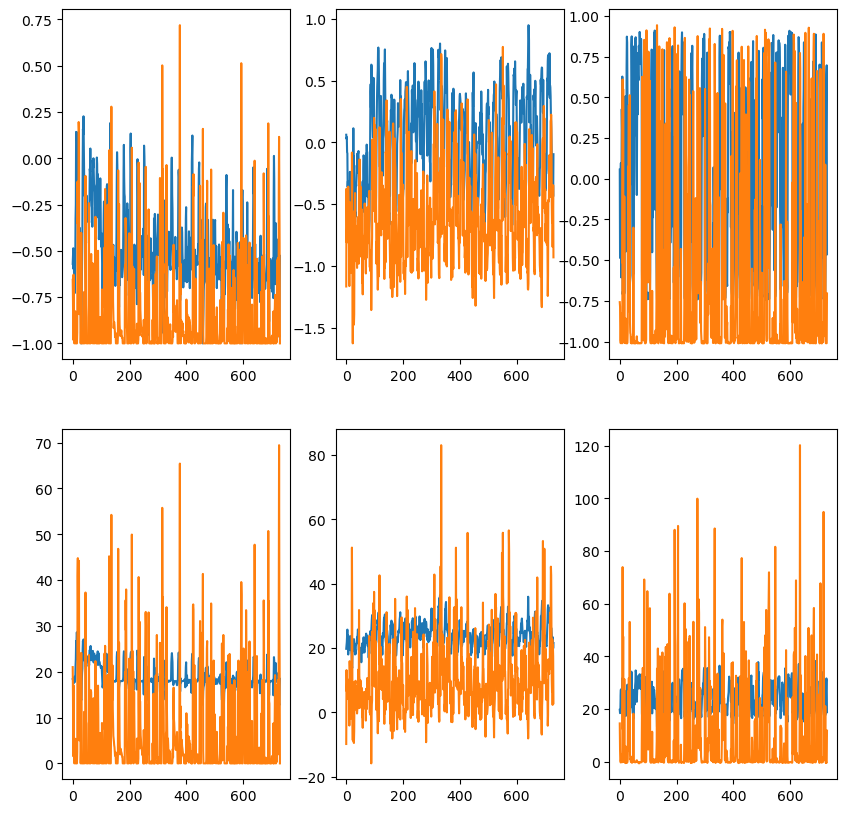

In [5]:
fig, ax = plt.subplots(2,3, figsize=(10,10))

datasets = [[base_data_train_scaled, base_data_train], 
            [vae_data_train, vae_data_train_rescaled], 
            [gan_data_train, gan_data_train_rescaled]]
for i, dataset in enumerate(datasets):
    ax[0,i].plot(dataset[0][10])
    ax[1,i].plot(dataset[1][10])


In [6]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

df = pd.DataFrame(base_data_train_scaled.reshape(-1,2), columns=['G.air.T', 'G.E_th_I'])

forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(),
    lags = 24
)

forecaster.fit(y=df['G.E_th_I'], exog=df['G.air.T'])

In [17]:
print(df['G.air.T'].index.max())

78839


In [ ]:
exog_var = pd.Series(base_data_test_scaled[:,:,0].reshape(-1))
exog_var.index = exog_var.index + df['G.air.T'].index.max() + 1

predictions = forecaster.predict(exog=exog_var, steps=730*12)

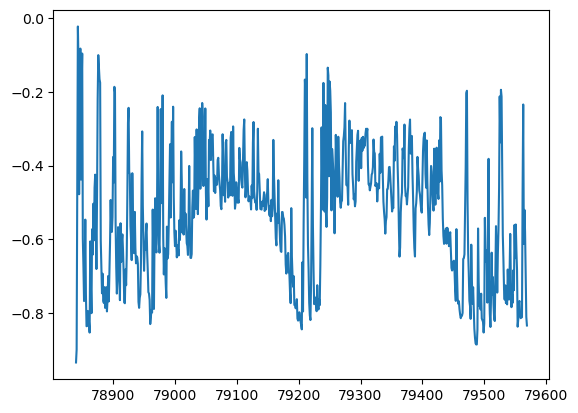

In [23]:
plt.plot(predictions)